# Import Libraries and read file

In [35]:
import matplotlib.pyplot as plt
import astropy
import yt
import numpy as np
import os 
from matplotlib.patches import Rectangle

# elephant
hdf5_root = "/srv/data/stratbox_simulations/stratbox_particle_runs/bx5/smd132/sn34/pe300/4pc_resume/4pc"

# s01.leaves
# hdf5_root = "/home/joy0921/Desktop/Dataset/hdf5_files"

ds = yt.load(os.path.join(hdf5_root, 'sn34_smd132_bx5_pe300_hdf5_plt_cnt_0206'))

center = [0, 0, 0] * yt.units.pc
arb_center = ds.arr(center, 'code_length')
xlim = 256
ylim = 256
zlim= 256
left_edge = arb_center - ds.quan(xlim // 2, 'pc')
right_edge = arb_center + ds.quan(ylim // 2, 'pc')
obj = ds.arbitrary_grid(left_edge, right_edge, dims=[xlim, ylim, zlim])

yt : [INFO     ] 2024-03-12 17:25:59,307 Particle file found: sn34_smd132_bx5_pe300_hdf5_part_0206


yt : [INFO     ] 2024-03-12 17:25:59,371 Parameters: current_time              = 6046479403795140.0
yt : [INFO     ] 2024-03-12 17:25:59,372 Parameters: domain_dimensions         = [  32   32 1280]
yt : [INFO     ] 2024-03-12 17:25:59,372 Parameters: domain_left_edge          = [-1.54283879e+21 -1.54283879e+21 -6.17135516e+22]
yt : [INFO     ] 2024-03-12 17:25:59,373 Parameters: domain_right_edge         = [1.54283879e+21 1.54283879e+21 6.17135516e+22]
yt : [INFO     ] 2024-03-12 17:25:59,374 Parameters: cosmological_simulation   = 0


In [49]:
center_1000 = [0, 0, 0] * yt.units.pc
arb_center_1000 = ds.arr(center_1000, 'code_length')
xlim_1000 = 1000
ylim_1000 = 1000
zlim_1000 = 1000
left_edge_1000 = arb_center_1000 - ds.quan(xlim_1000 // 2, 'pc')
right_edge_1000 = arb_center_1000 + ds.quan(ylim_1000 // 2, 'pc')
obj_1000 = ds.arbitrary_grid(left_edge_1000, right_edge_1000, dims=[xlim_1000, ylim_1000, zlim_1000])

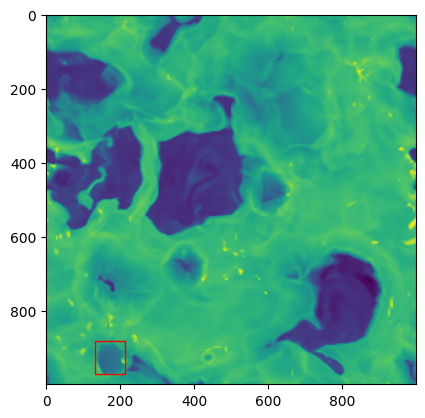

In [73]:
plt.imshow(np.log10(obj_1000['flash', 'dens'][:, :, 419].T[::-1]))      # slice: z = -91 pc
plt.gca().add_patch(Rectangle((-368 + 500, -(-382) + 500), 80, 90, linewidth=1, edgecolor='r', facecolor="none"))     

In [20]:
def get_velz_dens(x_range, y_range, z_range):
    # read a 3D grid of velz and density array
    velz = obj["flash", "velz"][x_range[0] : x_range[1], y_range[0] : y_range[1], z_range[0] : z_range[1]].to('km/s').value        
    dens = obj["flash", "dens"][x_range[0] : x_range[1], y_range[0] : y_range[1], z_range[0] : z_range[1]].to('g/cm**3').value          

    print(f"obj.shape: {obj['flash', 'velz'].shape}")
    print("x, y, z ranges: ", x_range, y_range, z_range)
    print(f"velz.shape: {velz.shape}\tdens.shape: {dens.shape}\n\n")      
     

    dz = obj['flash', 'dz'][x_range[0] : x_range[1], y_range[0] : y_range[1], z_range[0] : z_range[1]].to('cm').value
    mp = yt.physical_constants.mp.value # proton mass

    # calculate the density as column density
    coldens = dens * dz / (1.4 * mp)

    return velz, coldens

In [115]:
low_x0, low_y0, low_w, low_h, bottom_z, top_z = -500, -500, 1000, 1000, -500, 500

def pc2pixel(coord, x_y_z):
    if x_y_z == "x":
        return coord + top_z
    elif x_y_z == "y":
        return top_z - coord
    elif x_y_z == "z":
        return coord + top_z
    return coord

In [195]:
x_range, y_range, z_range = (pc2pixel(-500, x_y_z = 'x'), pc2pixel(-108, x_y_z = 'x')), (pc2pixel(-222, x_y_z = 'y'), pc2pixel(-500, x_y_z = 'y')), (pc2pixel(-136, x_y_z = 'z'), pc2pixel(34, x_y_z = 'z'))

x_range, y_range, z_range 



((0, 392), (722, 1000), (364, 534))

# Input cube coordinates, read dens values

In [196]:
# x_range, y_range, z_range = (-468, -188), (-572, -282), (-136, 34) #(-368, -288), (-418, -328), (-250, 250)  #(-136, 34) 

multiplier = 256 / 1000

# Multiply each element within the tuples by the multiplier
x_range_scaled = tuple(int(x * multiplier) for x in x_range)
y_range_scaled = tuple(int(y * multiplier) for y in y_range)
#z_range_scaled = z_range  
z_range_scaled = tuple(int(z * multiplier) for z in z_range)

new_velz, new_dens = get_velz_dens(x_range_scaled, y_range_scaled, z_range_scaled)

obj.shape: (256, 256, 256)
x, y, z ranges:  (0, 100) (184, 256) (93, 136)
velz.shape: (100, 72, 43)	dens.shape: (100, 72, 43)




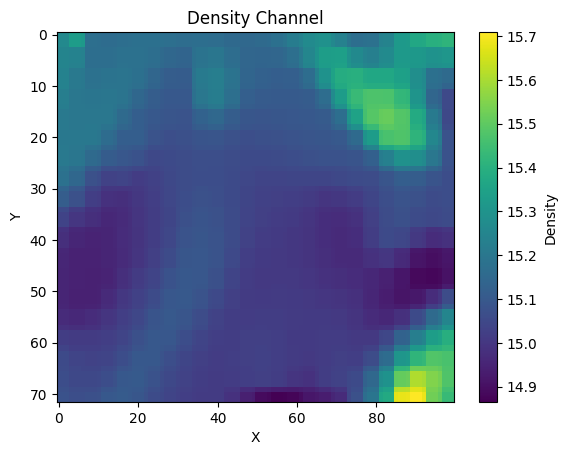

In [197]:
# Check if the region is actually what we wanted

fig, ax = plt.subplots()
im = ax.imshow(np.log10(new_dens[:, :, 22].T[::-1]), cmap='viridis', aspect='auto')
fig.colorbar(im, label='Density')
plt.title('Density Channel')
plt.xlabel('X')
plt.ylabel('Y')
# fig.savefig('channel_maps/dens.png')
plt.show()


In [202]:
# convert velz and dens to numpy array
velz_np = np.array(new_velz)
dens_np = np.array(new_dens)


# Filter the velz and dens arrays
velz_range = (2.5, 3.5) #(2.5, 2.75), (3.1, 3.5), (4.5, 4.9)
mask = (velz_np >= velz_range[0]) & (velz_np <= velz_range[1])
filtered_dens = np.where(mask, dens_np, 1) #dens_np[mask]

print(f"filtered_dens.shape: {filtered_dens.shape}\n")

mean_filtered_dens = np.nanmean(filtered_dens, axis=-1)
print(f"mean size: {mean_filtered_dens.shape}")



filtered_dens.shape: (100, 72, 43)

mean size: (100, 72)


## Channel Map generation

Text(0, 0.5, 'Y')

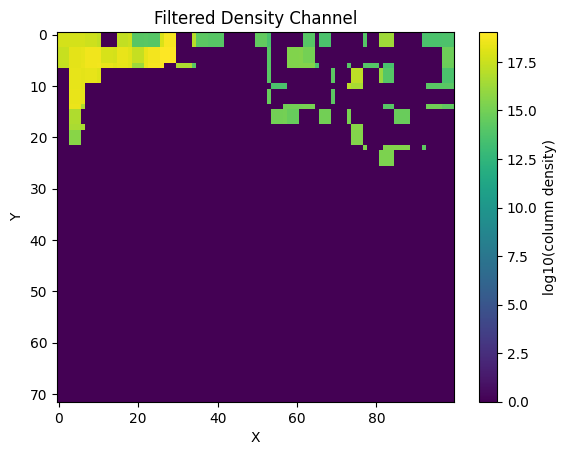

In [203]:
# Channel image
fig, ax = plt.subplots()
im = ax.imshow(np.log10(mean_filtered_dens.T[::-1]), cmap='viridis', aspect='auto')
fig.colorbar(im, label='log10(column density)')
plt.title('Filtered Density Channel')
plt.xlabel('X')
plt.ylabel('Y')
#fig.savefig('channel_maps/channel_image_49.png')

In [ ]:
# Uniform increments

for i in range(0, 100, 5):
    velz_range = (i / 10, (i / 10) + 0.5) 
    mask = (velz_np >= velz_range[0]) & (velz_np <= velz_range[1])
    filtered_dens = np.where(mask, dens_np, 1) 
    mean_filtered_dens = np.nanmean(filtered_dens, axis=-1)

    # saving the channel maps
    fig, ax = plt.subplots()
    im = ax.imshow(np.log10(mean_filtered_dens.T[::-1]), cmap='viridis', aspect='auto')
    fig.colorbar(im, label='log10(column density)')
    plt.title('Filtered Density Channel')
    plt.xlabel('X')
    plt.ylabel('Y')
    fig.savefig(f'channel_maps/channel_image_{i}.png')
    